In [215]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Operator, SparsePauliOp
import random as rand
import scipy.linalg as la
from qiskit.primitives import Estimator
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib import rcParams

In [216]:
Hamilton = SparsePauliOp(['IIIIII', 'IIIIIZ', 'IIIIXX', 'IIIIYY', 'IIIIZI', 'IIIXXI',
                          'IIIYYI', 'IIIZII', 'IIZIII', 'IIZIIZ', 'IXXIII', 'IYYIII', 
                          'IZIIII', 'IZIIZI', 'XXIIII', 'YYIIII', 'ZIIIII', 'ZIIZII'],
              [ 1.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j, -0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5+0.j,
 -0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5+0.j])

In [217]:
def qc_evolve_00(qc, numsite, time, hop, U, trotter_steps):
    numq = 2*numsite
    qc.unitary(Operator(la.expm(-1j*time*Hamilton)), range(numq) , label="Time_Trans")
    for i in range(numq):
        qc.measure(i, i)
    
def qc_evolve(qc, numsite, time, hop, U, trotter_steps):

    theta = hop*time/(2*trotter_slices) 
    phi = U*time/(trotter_slices)
    numq = 2*numsite
    
    y_hop = Operator([[np.cos(theta), 0, 0, -1j*np.sin(theta)],
                [0, np.cos(theta), 1j*np.sin(theta), 0],
                [0, 1j*np.sin(theta), np.cos(theta), 0],
                [-1j*np.sin(theta), 0, 0, np.cos(theta)]])
    x_hop = Operator([[np.cos(theta), 0, 0, 1j*np.sin(theta)],
                [0, np.cos(theta), 1j*np.sin(theta), 0],
                [0, 1j*np.sin(theta), np.cos(theta), 0],
                [1j*np.sin(theta), 0, 0, np.cos(theta)]])
    z_onsite = Operator([[1, 0, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, 0],
               [0, 0, 0, np.exp(1j*phi)]])
    
    #Loop over each time step needed and apply onsite and hopping gates
    for trot in range(trotter_steps):
        
        #Onsite Terms
        for i in range(0, numsite):
            qc.unitary(z_onsite, [i,i+numsite], label="Z_Onsite")
        
            #Add barrier to separate onsite from hopping terms    
            qc.barrier()
    
        #Hopping terms
        for i in range(0,numsite-1):
            #Spin-up chain
            qc.unitary(y_hop, [i,i+1], label="YHop")
            qc.unitary(x_hop, [i,i+1], label="Xhop")
            #Spin-down chain
            qc.unitary(y_hop, [i+numsite, i+1+numsite], label="Xhop")
            qc.unitary(x_hop, [i+numsite, i+1+numsite], label="Xhop")
            
            qc.barrier()

    estimator = Estimator()
    energy = estimator.run(qc, Hamilton).result()

    for i in range(numq):
        qc.measure(i, i)

    return energy.values[0]


def sys_evolve(nsites, excitations, total_time, dt, hop, U, trotter_steps, algo_index):
 
    numq = 2*nsites
    num_steps = int(total_time/dt)
    print('Num Steps: ',num_steps)
    print('Total Time: ', total_time)
    data = np.zeros((2**numq, num_steps))

    energy_list = []
    
    for t_step in range(0, num_steps):

        qcirc = QuantumCircuit(numq,numq)

        for flip in excitations:
            qcirc.x(flip)
            
        qcirc.barrier()

        if algo_index == 1:
            e_value = qc_evolve(qcirc, nsites, t_step*dt, hop, U, trotter_steps)
        else:
            e_value = qc_evolve_00(qcirc, nsites, t_step*dt, hop, U, trotter_steps)

        energy_list.append(e_value)
        backend = Aer.get_backend('qasm_simulator')
  
        job_run = transpile(qcirc, backend=backend) 
        job_exp = backend.run(job_run,shots=2048)
    
        result = job_exp.result()
        counts = result.get_counts(qcirc)
        print(result.get_counts(qcirc))
        print("Job: ",t_step+1, " of ", num_steps," complete.")

        for i in range(2**numq):
            dat = counts.get(format(i, 'b').zfill(numq))
            if dat == None:
                data[i,t_step] = 0
            else:
                data[i,t_step] = dat/2048
    return [data,energy_list]

Num Steps:  20
Total Time:  2.0
{'000011': 2048}
Job:  1  of  20  complete.
{'000011': 2022, '000101': 26}
Job:  2  of  20  complete.
{'000011': 1977, '000101': 71}
Job:  3  of  20  complete.
{'000011': 1864, '000101': 180, '000110': 4}
Job:  4  of  20  complete.
{'000011': 1736, '000101': 308, '000110': 4}
Job:  5  of  20  complete.
{'000011': 1561, '000101': 467, '000110': 20}
Job:  6  of  20  complete.
{'000011': 1402, '000101': 629, '000110': 17}
Job:  7  of  20  complete.
{'000011': 1217, '000101': 775, '000110': 56}
Job:  8  of  20  complete.
{'000101': 938, '000011': 1020, '000110': 90}
Job:  9  of  20  complete.
{'000101': 1049, '000011': 851, '000110': 148}
Job:  10  of  20  complete.
{'000101': 1153, '000011': 674, '000110': 221}
Job:  11  of  20  complete.
{'000101': 1238, '000011': 524, '000110': 286}
Job:  12  of  20  complete.
{'000101': 1248, '000110': 408, '000011': 392}
Job:  13  of  20  complete.
{'000101': 1230, '000110': 547, '000011': 271}
Job:  14  of  20  complet

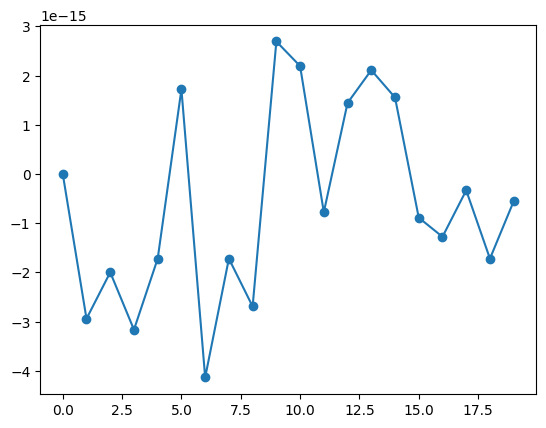

In [219]:
#==========Set Parameters of the System=============#
dt = 0.1 #Delta t
T = 2.0
time_steps = int(T/dt)
t = 1.0  #Hopping parameter
U = 2.0  #On-Site repulsion
nsites = 3
trotter_slices = 4
initial_state = np.array([1,0])

run_evolve = sys_evolve(nsites, initial_state, T, dt, t, U, trotter_slices,1)
run_results = run_evolve[0]
plt.plot(range(time_steps), run_evolve[1],'-o')
# run_evolve[1]

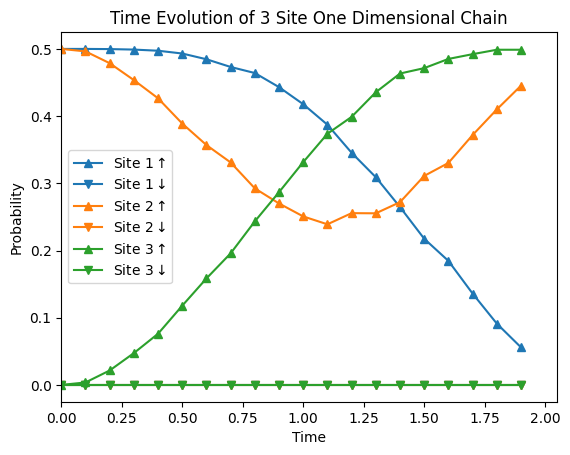

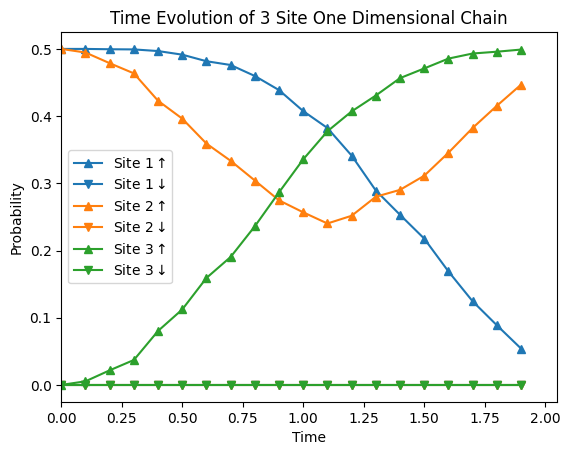

In [190]:
#Process and plot data


def reverse_list(s):
    temp_list = list(s)
    temp_list.reverse()
    return ''.join(temp_list)


#Useful tool for converting an integer to a binary bit string
def get_bin(x, n=0):
    """
    Get the binary representation of x.
    Parameters: x (int), n (int, number of digits)"""
    binry = format(x, 'b').zfill(n)
    sup = list( reversed( binry[0:int(len(binry)/2)] ) )
    sdn = list( reversed( binry[int(len(binry)/2):len(binry)] ) )
    return format(x, 'b').zfill(n)


def make_probability_plot(run_results):
    
    '''The procedure here is, for each fermionic mode, add the probability of every state containing
    that mode (at a given time step), and renormalize the data based on the total occupation of each mode.
    Afterwards, plot the data as a function of time step for each mode.'''
    
    proc_data = np.zeros((2*nsites, time_steps))
    timesq = np.arange(0.,time_steps*dt, dt)
    
    #Sum over time steps
    for t in range(time_steps):
        #Sum over all possible states of computer
        for i in range(2**(2*nsites)):
            #num = get_bin(i, 2*nsite)
            num = ''.join( list( reversed(get_bin(i,2*nsites)) ) )
            #For each state, check which mode(s) it contains and add them
            for mode in range(len(num)):
                if num[mode]=='1':
                    proc_data[mode,t] += run_results[i,t]
        
        #Renormalize these sums so that the total occupation of the modes is 1
        norm = 0.0
        for mode in range(len(num)):
            norm += proc_data[mode,t]
        proc_data[:,t] = proc_data[:,t] / norm
        
       
    #Create plots of the processed data
    fig2, ax2 = plt.subplots()
    colors = list(mcolors.TABLEAU_COLORS.keys())
    
    for i in range(nsites):
        #Create string label
        strup = "Site "+str(i+1)+r'$\uparrow$'
        strdwn = "Site "+str(i+1)+r'$\downarrow$'
        ax2.plot(timesq, proc_data[i,:], marker="^", color=str(colors[i]), label=strup)
        ax2.plot(timesq, proc_data[i+nsites,:], marker="v", color=str(colors[i]), label=strdwn)
        # ax2.plot(timesq, proc_data[i,:] + proc_data[i+nsites,:] , marker="*", color=str(colors[i]), label=strup)
    
    
    ax2.set_xlim(0, time_steps*dt+dt/2.)
    ax2.tick_params()
    ax2.set_title('Time Evolution of 3 Site One Dimensional Chain')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Probability')
    ax2.legend()

make_probability_plot(run_results_0)
make_probability_plot(run_results_1)

Time Steps:  50  Step Size:  0.1


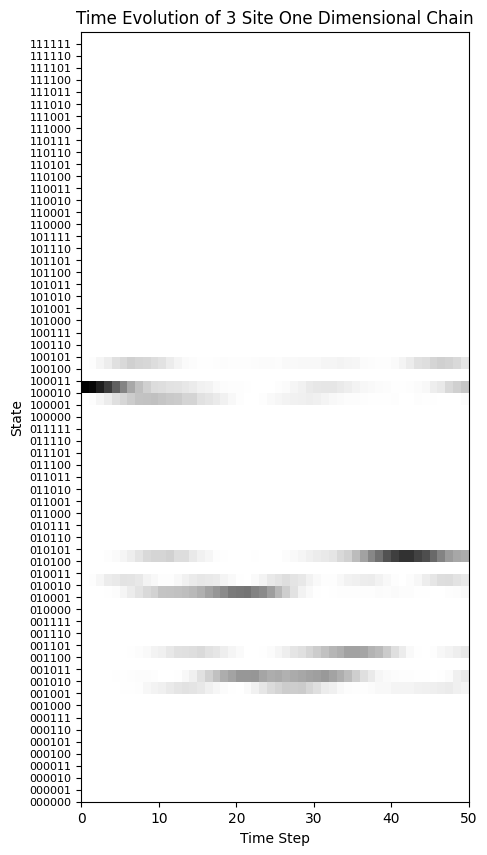

In [163]:
#Plot the raw data as a colormap
nsite = 3
xticks = np.arange(2**(nsite*2))
xlabels=[]
print("Time Steps: ",time_steps, " Step Size: ",dt)
for i in range(2**(nsite*2)):
    xlabels.append(get_bin(i,6))
    
fig, ax = plt.subplots(figsize=(5,10))
c = ax.pcolor(run_results_0, cmap='binary')
ax.set_title('Time Evolution of 3 Site One Dimensional Chain', fontsize=12)
plt.yticks(xticks, xlabels, size=8)
ax.set_xlabel('Time Step', fontsize=10)
ax.set_ylabel('State', fontsize=10)
plt.show()